# 1.0 - LogRank & RMST comparison

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import lifelines

In [2]:
GENESET = "Hallmarks"

logrank_test = pd.read_csv(f"../data/{GENESET}/logrank-scores-test-statistic.tsv", sep="\t", index_col=[0]).fillna(0)
logrank_pval = pd.read_csv(f"../data/{GENESET}/logrank-scores-p-value.tsv", sep="\t", index_col=[0]).fillna(1)
rmst_scores = pd.read_csv(f"../data/{GENESET}/rmst-difference-scores.tsv", sep="\t", index_col=[0]).fillna(0)

In [3]:
TIME_LIMIT_PERCENTILE = 75

# normalize RMST scores
for tcga in rmst_scores.columns:

    clinical = pd.read_csv(f"../tcga-data/data/raw/TCGA-{tcga}-survival.csv").dropna()
    time_limit = np.percentile(clinical["time"].values, TIME_LIMIT_PERCENTILE)
    rmst_scores[tcga] = rmst_scores[tcga]/time_limit

## General comparison on datasets

In [4]:
TCGA_DATASETS = ["LGG", "KIRC", "SKCM", "LIHC"]

In [5]:
def plot_KM(TCGA, HALLMARK, ax):
    survival_data = pd.read_csv(f"../tcga-data/data/raw/TCGA-{TCGA}-survival.csv", sep=",", index_col=[0]).dropna()
    ssgsea_data = pd.read_csv(f"../data/{GENESET}/TCGA-{TCGA}-ssGSEA.tsv", sep="\t", index_col=[0])

    common_ids = list(set(survival_data.index.values).intersection(ssgsea_data.index.values))
    survival_data = survival_data.loc[common_ids]
    ssgsea_data = ssgsea_data.loc[common_ids]

    time_limit_75 = np.percentile(survival_data["time"].values, TIME_LIMIT_PERCENTILE)

    ch1 = ssgsea_data[ssgsea_data[HALLMARK] > ssgsea_data[HALLMARK].median()].index
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(survival_data.loc[ch1, "time"], survival_data.loc[ch1, "event"])

    kmf2 = lifelines.KaplanMeierFitter()
    kmf2.fit(survival_data.loc[~survival_data.index.isin(ch1), "time"], survival_data.loc[~survival_data.index.isin(ch1), "event"])

    #kmf_overall = lifelines.KaplanMeierFitter()
    #kmf_overall.fit(survival_data["time"], survival_data["event"])

    kmf.plot(ax=ax, label="Enriched", color="red", ci_alpha=0.1) #, at_risk_counts=True)
    kmf2.plot(ax=ax, label="Non-enriched", color="k", ci_alpha=0.1)
    #kmf_overall.plot(ax=ax, label="", color="white", alpha=0.0, ci_alpha=0.0, zorder=0, at_risk_counts=True)

    ax.legend(frameon=False, fontsize=12)
    ax.plot([time_limit_75, time_limit_75], [0, 1], ls="--", color="gray")
    ax.text(time_limit_75, 1, " 75%", verticalalignment="top")

    ax.text(0, 0, f"{TCGA} // {HALLMARK}", fontsize=10, verticalalignment="top")
    ax.set_ylim(bottom=-0.1)

    for loc in ["top", "right"]:
        ax.spines[loc].set_visible(False)

/tmp/ipykernel_338345/238355987.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  top_ax[i].scatter(
/tmp/ipykernel_338345/238355987.py:58: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  top_ax[i*3].scatter(


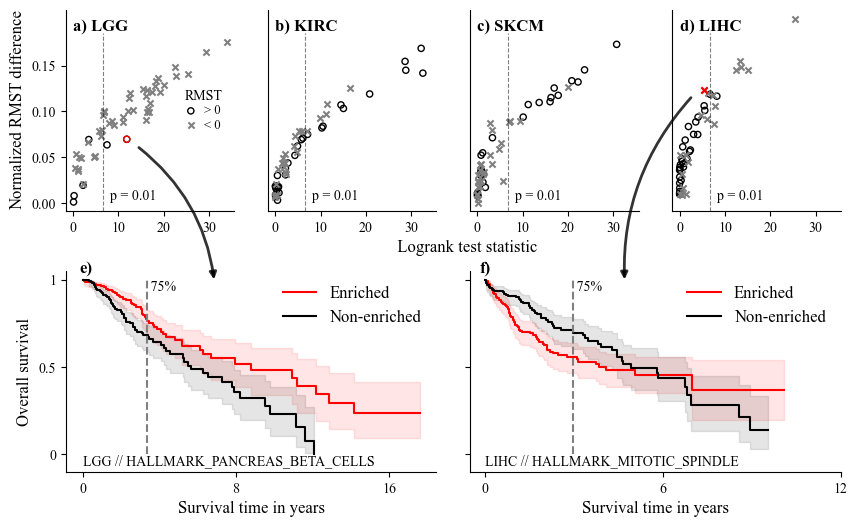

In [6]:
plt.rcParams["font.family"] = "Times New Roman"

f = plt.figure(figsize=(10,6))
top_gridspec = plt.GridSpec(2, 4, hspace=0.3)
bot_gridspec = plt.GridSpec(2, 4, hspace=0.3)

top_ax = [f.add_subplot(top_gridspec[0, i]) for i in range(4)]
bot_ax = [f.add_subplot(bot_gridspec[1, i:i+2]) for i in range(0,4, 2)]

for i, tcga in enumerate(TCGA_DATASETS):
    for positive, marker in zip([True, False], ["o", "x"]):

        ids = np.where((rmst_scores[tcga].values >= 0) == positive)[0].flatten()
        x = logrank_test[tcga].iloc[ids].values
        y = np.abs(rmst_scores[tcga].iloc[ids].values)

        top_ax[i].scatter(
            x, y,
            s=20, edgecolors="k", facecolor="none" if marker == "o" else "gray",
            marker=marker,
            label=None if i != 0 else ("> 0" if positive else "< 0")
        )

top_ax[0].legend(fontsize=9, frameon=False, title="RMST", labelspacing=0.2, handlelength=0.5, loc=7)
    

top_xlim = (min([top_ax[i].get_xlim()[0] for i in range(4)]), max([top_ax[i].get_xlim()[1] for i in range(4)]))
top_ylim = (min([top_ax[i].get_ylim()[0] for i in range(4)]), max([top_ax[i].get_ylim()[1] for i in range(4)]))

for i in range(4):

    top_ax[i].vlines(6.635, top_ylim[0], 0.185, color="k", ls="--", alpha=0.5, lw=0.8)
    top_ax[i].text(6.635, 0, "  p = 0.01", fontsize=10, horizontalalignment="left", verticalalignment="bottom")

    top_ax[i].set_ylim(top_ylim)
    top_ax[i].set_xlim(top_xlim)

    for loc in ["top", "right"]:
        top_ax[i].spines[loc].set_visible(False)
    
    if i != 0:
        top_ax[i].set_yticks([])
    else:
        top_ax[i].set_yticks([0, 0.05, 0.1, 0.15])

for i, (letter, label) in enumerate(zip(list("abcd"), TCGA_DATASETS)):
    top_ax[i].text(
        0, 0.20, f"{letter}) {label}", weight="bold", fontsize=12,
        horizontalalignment="left", verticalalignment="top"
    )

for i, (tcga, geneset) in enumerate(zip(["LGG", "LIHC"], ["HALLMARK_PANCREAS_BETA_CELLS", "HALLMARK_MITOTIC_SPINDLE"])):

    plot_KM(tcga, geneset, bot_ax[i])
    bot_ax[i].set_yticks([0, 0.5, 1], labels=[0, 0.5, 1] if i == 0 else [""]*3)

    marker="o" if rmst_scores.loc[geneset, tcga] > 0 else "x"
    top_ax[i*3].scatter(
        logrank_test.loc[geneset, tcga], np.abs(rmst_scores.loc[geneset, tcga]),
        s=20, edgecolors="red", facecolor="none" if marker == "o" else "red", marker=marker)

# axis labels
FS = 12
top_ax[0].set_ylabel("Normalized RMST difference", fontsize=FS)
top_ax[1].set_xlabel("           Logrank test statistic", fontsize=FS, horizontalalignment="left")
bot_ax[0].set_ylabel("Overall survival", fontsize=FS)

# Arrow starting point in top_ax[1] in data coordinates

for i, (start_coords, end_coords) in enumerate(zip([(14.5, 0.060583), (2.5, 0.115)], [(2500, 1), (1500, 1)])):
    # Transform start point to figure coordinates
    start_display = top_ax[i*3].transData.transform(start_coords)
    start_fig = f.transFigure.inverted().transform(start_display)

    # Arrow end point in bot_ax[0] in data coordinates

    # Transform end point to figure coordinates
    end_display = bot_ax[i].transData.transform(end_coords)
    end_fig = f.transFigure.inverted().transform(end_display)

    # Create the arrow
    con = ConnectionPatch(xyA=start_fig, xyB=end_fig, coordsA="figure fraction", coordsB="figure fraction",
                        axesA=None, axesB=None, arrowstyle="-|>", color="k", lw=2,
                        connectionstyle="arc3,rad=0.2" if i != 0 else "arc3,rad=-0.2", alpha=0.8)

    # Add the arrow to the figure
    f.add_artist(con)

for i, (letter, xtick_num) in enumerate(zip(list("ef"), [[0,8,16], [0, 6, 12]])):
    YEAR = 365
    xticks = [k * YEAR for k in xtick_num]
    bot_ax[i].set_xticks(xticks, labels=xtick_num)
    bot_ax[i].set_xlabel("Survival time in years", fontsize=FS)
    bot_ax[i].text(-0.2*YEAR, 1.02, f"{letter})", fontsize=12, weight="bold", verticalalignment="bottom", horizontalalignment="left")

f.savefig("../figures/logrank-rmst-comparison-KM.pdf", dpi=500, bbox_inches="tight")

## Table of results for Latex

In [8]:
tcga_grouped = {}

for tcga in logrank_pval.columns:
    x = pd.concat((
        pd.Series(ss.false_discovery_control(logrank_pval[tcga].values), index=logrank_pval.index),
        logrank_test[tcga],
        np.abs(rmst_scores[tcga])
    ), axis=1)
    x.columns = ["p-value", "logrank", "rmst"]

    tcga_grouped[tcga] = x

In [9]:
results = []
for tcga in tcga_grouped.keys():
    results += [(tcga, tcga_grouped[tcga].min().loc["p-value"])]
projects = [x[0] for x in sorted(results, key=lambda x: x[1], reverse=False)][:5]

In [10]:
for p in projects:
    x = tcga_grouped[p].sort_values(by=["logrank"], ascending=False).iloc[0]
    rmst_rank = 50-np.argsort(np.argsort(np.abs(tcga_grouped[p].sort_values(by=["logrank"], ascending=False))["rmst"]))[0]
    
    underscore, backslash_underscore = "_", "\_"
    backslash = "\\"
    brakets = "{}"
    print(f"{p} & {x.name.split('HALLMARK_')[1].replace(underscore, backslash_underscore)} & {x.loc['logrank']:.1f} & {x.loc['p-value']:.1e} & {rmst_rank} &  {backslash}cite{brakets} {backslash}{backslash}")

LGG & EPITHELIAL\_MESENCHYMAL\_TRANSITION & 33.9 & 3.0e-07 & 1 &  \cite{} \\
KIRC & FATTY\_ACID\_METABOLISM & 32.5 & 3.5e-07 & 4 &  \cite{} \\
SKCM & INTERFERON\_ALPHA\_RESPONSE & 30.7 & 1.5e-06 & 1 &  \cite{} \\
LIHC & SPERMATOGENESIS & 25.5 & 2.2e-05 & 1 &  \cite{} \\
LAML & FATTY\_ACID\_METABOLISM & 24.5 & 3.6e-05 & 1 &  \cite{} \\


## Spearman R of significant results between Log-rank and RMST

In [15]:
s = [x.statistic for x in spearmans]
np.mean(s), np.std(s)/np.sqrt(len(s))

(0.8562224889955982, 0.027137906654976198)

In [16]:
np.random.seed(0)
s_boot = [np.mean(np.random.choice(s, size=len(s), replace=True)) for _ in range(1000)]
np.mean(s_boot), (np.percentile(s_boot, 97.5) - np.percentile(s_boot, 2.5))/4

(0.8570722368947579, 0.0264937975190076)

## Dataset statistics

In [17]:
import os
import sys
import pandas as pd

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from src.utils.constants import TCGA_DATASETS

print("TCGA", "N samples", "% censored")
for tcga in TCGA_DATASETS:
    d = pd.read_csv(f"../tcga-data/data/TCGA-{tcga}.csv", sep=",", index_col=[0])
    d = d[d.columns[:2]]
    print(tcga, len(d), 1- np.sum(d["event"])/len(d))

CESC 305 0.7639344262295082
ESCA 185 0.5783783783783784
UCEC 553 0.8318264014466547
SARC 263 0.623574144486692
PAAD 179 0.4804469273743017
COAD 474 0.7827004219409283
LAML 140 0.37857142857142856
LGG 532 0.7443609022556391
LIHC 372 0.6505376344086021
BRCA 1116 0.8620071684587813
STAD 404 0.6138613861386139
KIRC 542 0.6771217712177122
BLCA 406 0.5541871921182266
LUAD 531 0.6440677966101696
LUSC 495 0.5737373737373737
SKCM 462 0.5238095238095238
HNSC 519 0.5741811175337187
OV 426 0.3802816901408451
GBM 169 0.1952662721893491
